## Pre-Requisites

Import dependencies

In [22]:
import numpy as np
from PIL import Image
from scipy.fftpack import idct
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
import cv2
import pickle

Define some helper functions for image displaying

In [23]:
# Helper function to show a single image in a plot
def show_image(img):
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()

# Helper function to show two images side by side in a plot
def show_image_side_by_side(img1, img2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))
    ax1.imshow(img1, cmap='gray')
    ax1.set_title(title1)
    ax1.axis('off')
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2)
    ax2.axis('off')
    plt.show()

---

## Decompressing the image

Decode the 'test.bin' and reconstruct the 8x8 blocks for each channel

In [24]:
def decode_huffman_and_reconstruct_blocks(file_path):
    with open(file_path, "rb") as f:
        # Read and deserialize the combined data and metadata
        combined_data = pickle.loads(f.read())

    # Extract metadata
    metadata = pickle.loads(combined_data["metadata"])
    Q = np.array(metadata["Q"])
    QP = metadata["QP"]
    img_shape = metadata["shape"]

    # Deserialize Huffman codecs
    y_huffman_codec = pickle.loads(metadata["y_codec"])
    cb_huffman_codec = pickle.loads(metadata["cb_codec"])
    cr_huffman_codec = pickle.loads(metadata["cr_codec"])

    # Decode each channel's data
    y_decoded_data = y_huffman_codec.decode(combined_data["y_data"])
    cb_decoded_data = cb_huffman_codec.decode(combined_data["cb_data"])
    cr_decoded_data = cr_huffman_codec.decode(combined_data["cr_data"])

    # Deserialize blocks into their original shape
    y_blocks_decoded = [np.array(block).reshape(8, 8) for block in pickle.loads(y_decoded_data)]
    cb_blocks_decoded = [np.array(block).reshape(8, 8) for block in pickle.loads(cb_decoded_data)]
    cr_blocks_decoded = [np.array(block).reshape(8, 8) for block in pickle.loads(cr_decoded_data)]

    return y_blocks_decoded, cb_blocks_decoded, cr_blocks_decoded, Q, QP, img_shape

file_path = "output/test.bin"
y_blocks_decoded, cb_blocks_decoded, cr_blocks_decoded, Q, QP, img_shape = decode_huffman_and_reconstruct_blocks(file_path)


Dequantize the blocks

In [25]:
# Calculate the quantization matrix based on the given factor QP
quantization_matrix = np.round(Q * QP)

y_blocks_dequantized = [block * quantization_matrix for block in y_blocks_decoded]
cb_blocks_dequantized = [block * quantization_matrix for block in cb_blocks_decoded]
cr_blocks_dequantized = [block * quantization_matrix for block in cr_blocks_decoded]


Perform the inverse DCT on each block

In [26]:
# Inverse DCT
y_blocks_idct = [idct(block, norm='ortho') for block in y_blocks_dequantized]
cb_blocks_idct = [idct(block, norm='ortho') for block in cb_blocks_dequantized]
cr_blocks_idct = [idct(block, norm='ortho') for block in cr_blocks_dequantized]

Reconstruct each channel after IDCT and merge them again into an image

In [27]:
# Initialize reconstructed channels using the original image dimensions
y_reconstructed = np.zeros(img_shape)
cb_reconstructed = np.zeros(img_shape)
cr_reconstructed = np.zeros(img_shape)

# Iterate over the image by 8x8 blocks
for i in range(0, img_shape[0], 8):
    for j in range(0, img_shape[1], 8):
        # Calculate block index
        block_index = (i // 8) * (img_shape[1] // 8) + (j // 8)
        
        # Reconstruct each channel and add 128 to each pixel to recenter the values around 0
        y_reconstructed[i:i+8, j:j+8] = y_blocks_idct[block_index] + 128
        cb_reconstructed[i:i+8, j:j+8] = cb_blocks_idct[block_index] + 128
        cr_reconstructed[i:i+8, j:j+8] = cr_blocks_idct[block_index] + 128


# Convert y, cb, and cr channels to uint8
y_reconstructed = np.clip(y_reconstructed, 0, 255).astype(np.uint8)
cb_reconstructed = np.clip(cb_reconstructed, 0, 255).astype(np.uint8)
cr_reconstructed = np.clip(cr_reconstructed, 0, 255).astype(np.uint8)

# Merge the channels
merged_yuv = cv2.merge([y_reconstructed, cb_reconstructed, cr_reconstructed])
reconstructed_img = Image.fromarray(merged_yuv, mode='YCbCr')
reconstructed_img = reconstructed_img.convert('RGB')

Compare with the original image and calculate the PSNR

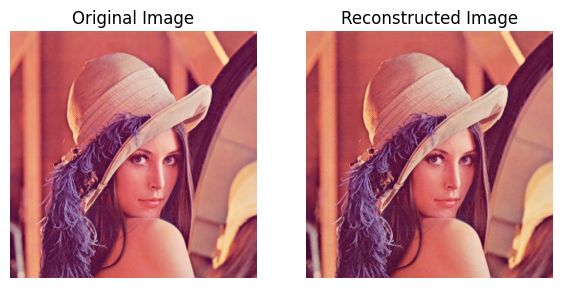

PSNR: 31.97705328628143


In [28]:
# Compare with the original image
img = Image.open("assets/test.png")
show_image_side_by_side(img, reconstructed_img, 'Original Image', 'Reconstructed Image')

#Calculate PSNR
print('PSNR:', psnr(np.array(img), np.array(reconstructed_img)))

#Save the reconstructed image
reconstructed_img.save("output/rec.png")